In [24]:
paths = [
    "..",
]
import sys
for path in paths:
    if path not in sys.path:
        sys.path.insert(0, path)
        
import numpy as np
import torch
from matplotlib import pyplot as plt
from pytorch_lightning.utilities import AttributeDict

from neural_field_optimal_planner.collision_checker import CircleDirectedCollisionChecker, RectangleCollisionChecker
from neural_field_optimal_planner.planner_factory import PlannerFactory
from neural_field_optimal_planner.plotting_utils import *
from neural_field_optimal_planner.test_environment_builder import TestEnvironmentBuilder
from neural_field_optimal_planner.utils.position2 import Position2

torch.random.manual_seed(100)
np.random.seed(400)
from dataclasses import dataclass
import cv2
from neural_field_optimal_planner.collision_checker import CollisionChecker

# U-shape planner

In [65]:
@dataclass
class MapImage:
    cols: int
    rows: int
    origin_x: float
    origin_y: float
    cell_size: float
    map_image: np.array
    
class MapCollisionChecker(CollisionChecker):
    def __init__(self, map_image, boundaries=None):
        super().__init__(boundaries)
        self._map_image = map_image

    def check_collision(self, test_positions):
        test_positions = test_positions.translation
        image_points = self._map_image_from_point(test_positions)
        mask = (image_points[:, 0] >= 0) & (image_points[:, 1] >= 0)
        mask &= (image_points[:, 1] < self._map_image.rows - 1) & (image_points[:, 0] < self._map_image.cols - 1)
        points = image_points[mask]
        collisions = self._map_image.map_image[points[:, 1], points[:, 0]] > 0
        result = np.zeros(test_positions.shape[0])
        result[mask] = collisions
        result[~mask] = True
        return result.astype(bool)
        
    def _map_image_from_point(self, points):
        x = (points[:, 0] - self._map_image.origin_x - self._map_image.cell_size  / 2) / self._map_image.cell_size 
        y = (points[:, 1] - self._map_image.origin_y - self._map_image.cell_size  / 2) / self._map_image.cell_size 
        return np.stack([x, y], axis=1).astype(np.int32)
    
def map_image_from_point(points, dataset):
    x = (points[:, 0] - dataset.origin_x) / dataset.cell_size 
    y = (points[:, 1] - dataset.origin_y) / dataset.cell_size 
    return np.stack([x, y], axis=1).astype(np.int32)

def draw_poly(points, dataset):
    points = map_image_from_point(points, dataset)
    dataset.map_image = cv2.fillConvexPoly(dataset.map_image, points, [255, 255, 255])

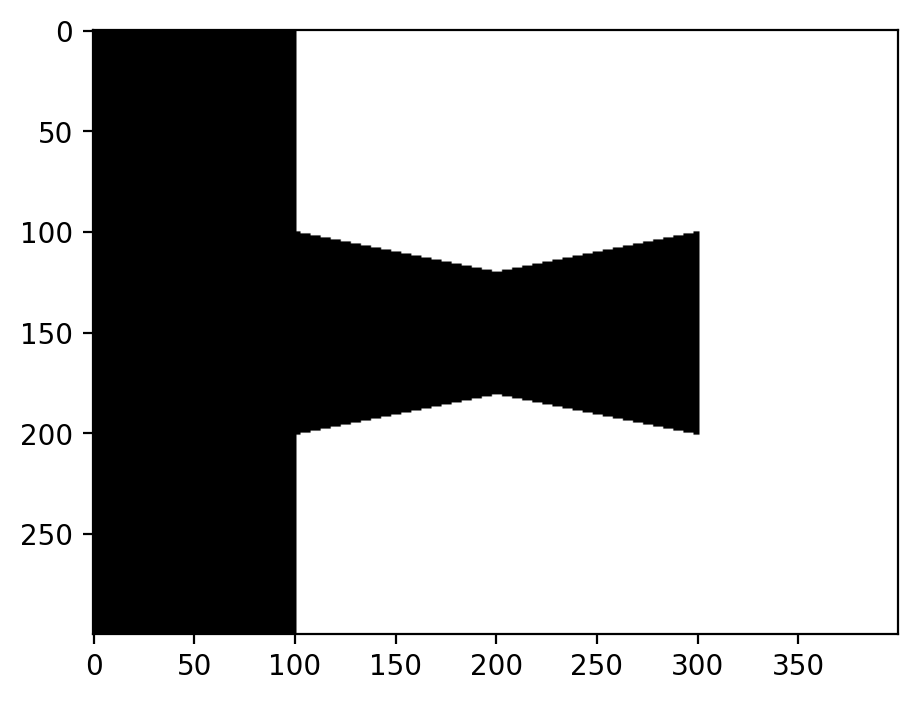

In [66]:
plt.figure(dpi=200)



map_image = MapImage(
    cols=400,
    rows=300,
    origin_x=-20,
    origin_y=-10,
    cell_size=0.1,
    map_image=None
)

map_image.map_image = np.zeros((map_image.rows, map_image.cols))
draw_poly(np.array([[-20, -10], [-20, 20], [-10, 20], [-10, -10]]), map_image)
draw_poly(np.array([[-10, 10], [0, 8], [0, 2], [-10, 0]]), map_image)
draw_poly(np.array([[0, 8], [0, 2], [10, 0], [10, 10]]), map_image)
plt.imshow(255 - map_image.map_image, cmap="gray")

In [67]:
collision_checker = MapCollisionChecker(map_image, (-20, 20, -10, 20))
points = np.random.rand(1000, 2)
points[:, 0] = points[:, 0] * 40 - 20
points[:, 1] = points[:, 1] * 30 - 10

# collisions = collision_checker.check_collision(points)
# plt.scatter(points[collisions, 0], points[collisions, 1])
# plt.scatter(points[~collisions, 0], points[~collisions, 1])

In [68]:
# class PlannerFactory(object):
#     @staticmethod
#     def make_onf_planner(collision_checker):
#         device = "cpu"
#         collision_model = ONF(1.5, 1).to(device)
#         collision_optimizer = torch.optim.Adam(collision_model.parameters(), 1e-3, betas=(0.9, 0.9))
#         trajectory = torch.zeros(100, 2, requires_grad=True, device=device)
#         trajectory_optimizer = torch.optim.Adam([trajectory], 1e-2, betas=(0.9, 0.999))
#         return NERFOptPlanner(trajectory, collision_model, collision_checker, collision_optimizer,
#                               trajectory_optimizer, trajectory_random_offset=0.02, collision_weight=0.01,
#                               velocity_hessian_weight=3, random_field_points=10, init_collision_iteration=400)

In [80]:
torch.random.manual_seed(100)
np.random.seed(400)
planner_parameters = AttributeDict(
    device="cpu",
    trajectory_length=20,
    collision_model=AttributeDict(
        mean=0,
        sigma=7,
        use_cos=True,
        bias=True,
        use_normal_init=True,
        angle_encoding=False,
        name="ONF"
    ),
    trajectory_initializer=AttributeDict(
        name="TrajectoryInitializer",
        resolution=0.05
    ),
    collision_optimizer=AttributeDict(
        lr=1e-3,
        betas=(0.9, 0.9)
    ),
    trajectory_optimizer=AttributeDict(
        lr=3e-2,
        betas=(0.9, 0.9)
    ),
    planner=AttributeDict(
        name="ConstrainedNERFOptPlanner",
        trajectory_random_offset=0.02,
        collision_weight=10,
        velocity_hessian_weight=0.5,
        random_field_points=10,
        init_collision_iteration=3,
        constraint_deltas_weight=20,
        multipliers_lr=0.1,
        init_collision_points=100,
        reparametrize_trajectory_freq=10,
        optimize_collision_model_freq=1,
        angle_weight=0.5,
        angle_offset=0.3,
        boundary_weight=1,
        collision_multipliers_lr=1e-3,
        course_random_offset=0.001,
    )
)


planner = PlannerFactory.make_constrained_onf_planner(collision_checker, planner_parameters)
goal_point = np.asarray([-8, -2, np.pi])
start_point = np.asarray([-8, 12, 0])
trajectory_boundaries = (-20, 20, -10, 20)
boundaries = trajectory_boundaries

planner.init(start_point, goal_point, trajectory_boundaries)
device = planner._device
collision_model = planner._collision_model
fig = plt.figure(1, dpi=200)

for i in range(1000):
    planner.step()
    trajectory = planner.get_path()
#     if i % 100 == 0:
#         fig.clear()
#         prepare_figure(trajectory_boundaries)
#         plot_planner_data(trajectory, collision_model, trajectory_boundaries, np.zeros((0, 2)), device=device)
#         # plot_nerf_opt_planner(planner)
#         # plot_collision_positions(planner.checked_positions, planner.truth_collision)
#         plt.pause(0.01)


<Figure size 1200x800 with 0 Axes>

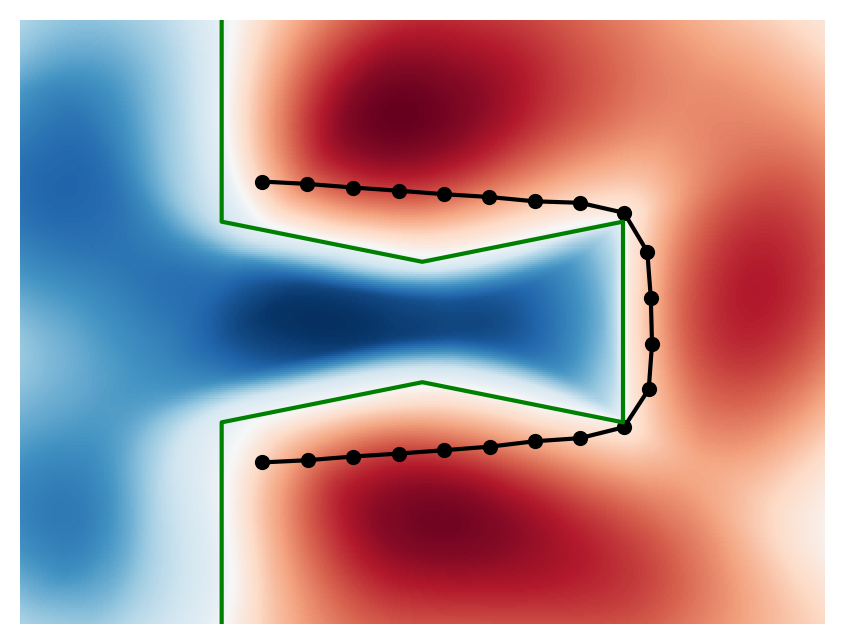

In [81]:
grid_x, grid_y = np.meshgrid(np.linspace(trajectory_boundaries[0], trajectory_boundaries[1], 400),
                             np.linspace(trajectory_boundaries[2], trajectory_boundaries[3], 300))
grid = np.stack([grid_x, grid_y, np.zeros_like(grid_x)], axis=2).reshape(-1, 3)
# obstacle_probabilities = nn.functional.softplus(model(torch.tensor(grid.astype(np.float32), device=device)))
obstacle_probabilities = collision_model(torch.tensor(grid.astype(np.float32), device=device))
obstacle_probabilities = obstacle_probabilities.cpu().detach().numpy().reshape(300, 400)

collisions = collision_checker.check_collision(Position2.from_vec(grid)).reshape(300, 400)

grid = grid.reshape(300, 400, 3)
plt.figure(dpi=200)
plt.gca().pcolormesh(grid[:, :, 0], grid[:, :, 1], obstacle_probabilities, cmap='RdBu', shading='auto')
# plt.gca().pcolormesh(grid[:, :, 0], grid[:, :, 1], collisions, cmap='RdBu', shading='auto')
plt.gca().axis('off')
plt.gca().set_aspect('equal')
plt.scatter(trajectory[:, 0], trajectory[:, 1], s=20, color="black")
plt.plot(trajectory[:, 0], trajectory[:, 1], color="black")
edge = np.array([[-10, 20], [-10, 10], [0, 8], [10, 10], [10, 0], [0, 2], [-10, 0], [-10, -10]])
plt.plot(edge[:, 0], edge[:, 1], c="green")

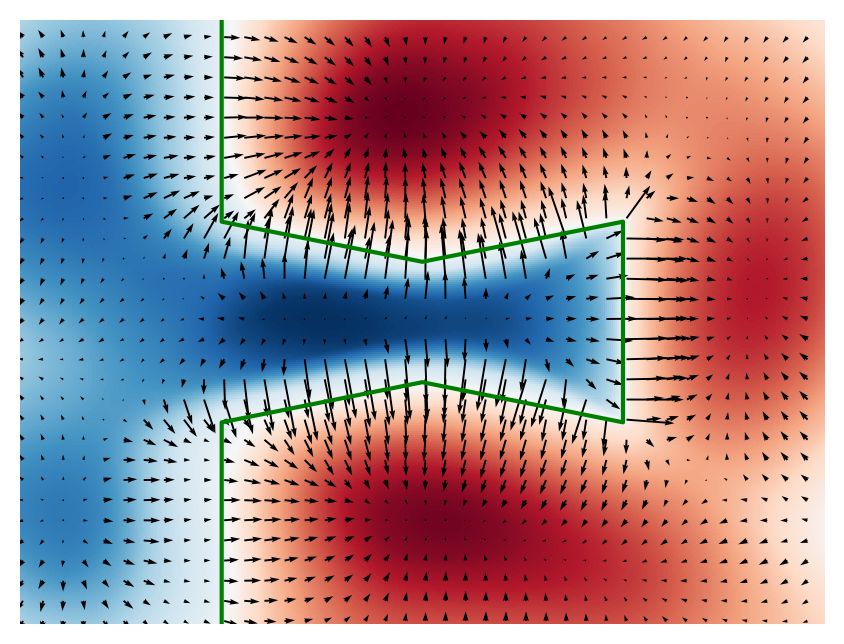

In [84]:
grid_x, grid_y = np.meshgrid(np.linspace(trajectory_boundaries[0], trajectory_boundaries[1], 400),
                             np.linspace(trajectory_boundaries[2], trajectory_boundaries[3], 300))
grid = np.stack([grid_x, grid_y, np.zeros_like(grid_x)], axis=2).reshape(-1, 3)
# obstacle_probabilities = nn.functional.softplus(model(torch.tensor(grid.astype(np.float32), device=device)))
obstacle_probabilities = collision_model(torch.tensor(grid.astype(np.float32), device=device))
obstacle_probabilities = obstacle_probabilities.cpu().detach().numpy().reshape(300, 400)

collisions = collision_checker.check_collision(Position2.from_vec(grid)).reshape(300, 400)

grid = grid.reshape(300, 400, 3)
plt.figure(dpi=200)
plt.gca().pcolormesh(grid[:, :, 0], grid[:, :, 1], obstacle_probabilities, cmap='RdBu', shading='auto')
# plt.gca().pcolormesh(grid[:, :, 0], grid[:, :, 1], collisions, cmap='RdBu', shading='auto')
plt.gca().axis('off')
plt.gca().set_aspect('equal')

dy = -(obstacle_probabilities[2:, 1:-1] - obstacle_probabilities[:-2, 1:-1])[::10, ::10]
dx = -(obstacle_probabilities[1:-1, 2:] - obstacle_probabilities[1:-1, :-2])[::10, ::10]
x = grid_x[1:-1, 1:-1][::10, ::10]
y = grid_y[1:-1, 1:-1][::10, ::10]
plt.quiver(x, y, dx, dy, color="black")
edge = np.array([[-10, 20], [-10, 10], [0, 8], [10, 10], [10, 0], [0, 2], [-10, 0], [-10, -10]])
plt.plot(edge[:, 0], edge[:, 1], c="green")

In [41]:
print(trajectory[:, :2])

[[-8.         12.        ]
 [-5.7314653  11.881608  ]
 [-3.4524329  11.701319  ]
 [-1.1804763  11.542024  ]
 [ 1.0789251  11.370574  ]
 [ 3.339159   11.229115  ]
 [ 5.5930433  11.014684  ]
 [ 7.8553696  10.940255  ]
 [10.056276   10.4413595 ]
 [11.210006    8.507132  ]
 [11.3857765   6.217959  ]
 [11.44803     3.9123356 ]
 [11.282219    1.6472638 ]
 [10.051938   -0.24207655]
 [ 7.8554697  -0.7883848 ]
 [ 5.59683    -0.9444567 ]
 [ 3.34887    -1.2143525 ]
 [ 1.0898356  -1.390593  ]
 [-1.1703094  -1.5577848 ]
 [-3.4359682  -1.7036059 ]
 [-5.722002   -1.8884432 ]
 [-8.         -2.        ]]


# Planner

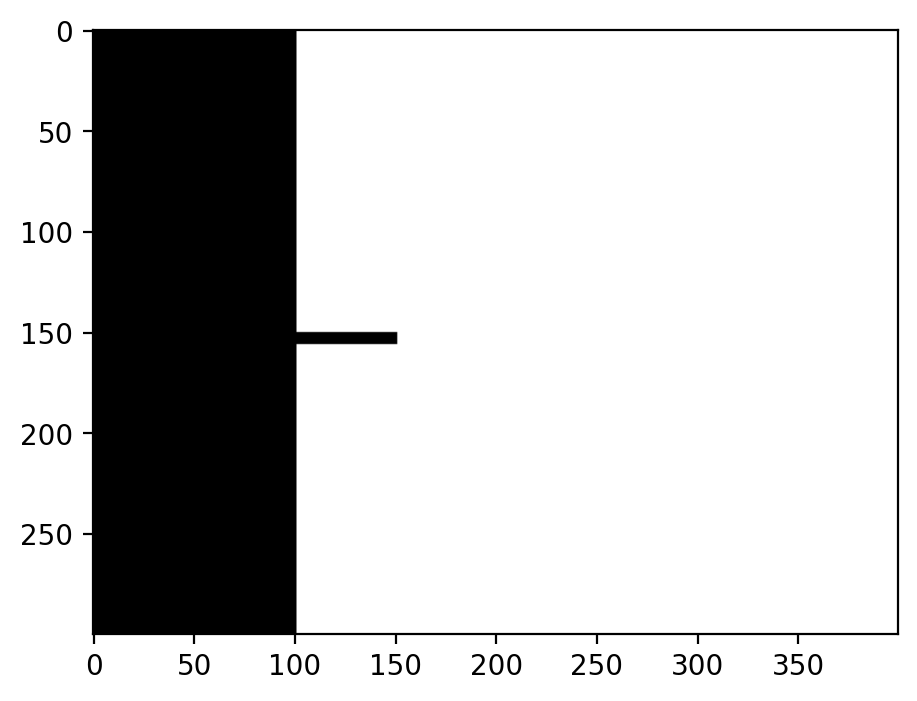

In [56]:
plt.figure(dpi=200)



map_image = MapImage(
    cols=400,
    rows=300,
    origin_x=-20,
    origin_y=-10,
    cell_size=0.1,
    map_image=None
)

map_image.map_image = np.zeros((map_image.rows, map_image.cols))
draw_poly(np.array([[-20, -10], [-20, 20], [-10, 20], [-10, -10]]), map_image)
draw_poly(np.array([[-10, 5], [-5, 5], [-5, 5.5], [-10, 5.5]]), map_image)
# draw_poly(np.array([[-10, 5], [5, 5], [5, 5.5], [-10, 5.5]]), map_image)
plt.imshow(255 - map_image.map_image, cmap="gray")

In [57]:
collision_checker = MapCollisionChecker(map_image, (-20, 20, -10, 20))
points = np.random.rand(1000, 2)
points[:, 0] = points[:, 0] * 40 - 20
points[:, 1] = points[:, 1] * 30 - 10

# collisions = collision_checker.check_collision(points)
# plt.scatter(points[collisions, 0], points[collisions, 1])
# plt.scatter(points[~collisions, 0], points[~collisions, 1])

In [58]:
torch.random.manual_seed(100)
np.random.seed(400)
planner_parameters = AttributeDict(
    device="cpu",
    trajectory_length=20,
    collision_model=AttributeDict(
        mean=0,
        sigma=3,
        use_cos=True,
        bias=True,
        use_normal_init=True,
        angle_encoding=False,
        name="ONF"
    ),
    trajectory_initializer=AttributeDict(
        name="TrajectoryInitializer",
        resolution=0.05
    ),
    collision_optimizer=AttributeDict(
        lr=1e-2,
        betas=(0.9, 0.9)
    ),
    trajectory_optimizer=AttributeDict(
        lr=3e-2,
        betas=(0.9, 0.9)
    ),
    planner=AttributeDict(
        name="ConstrainedNERFOptPlanner",
        trajectory_random_offset=0.02,
        collision_weight=100,
        velocity_hessian_weight=0.5,
        random_field_points=10,
        init_collision_iteration=3,
        constraint_deltas_weight=20,
        multipliers_lr=0.1,
        init_collision_points=100,
        reparametrize_trajectory_freq=10,
        optimize_collision_model_freq=1,
        angle_weight=0.5,
        angle_offset=0.3,
        boundary_weight=1,
        collision_multipliers_lr=1e-3,
        course_random_offset=5,
    )
)


planner = PlannerFactory.make_constrained_onf_planner(collision_checker, planner_parameters)
goal_point = np.asarray([-8, -2, np.pi])
start_point = np.asarray([-8, 12, 0])
trajectory_boundaries = (-20, 20, -10, 20)

planner.init(start_point, goal_point, trajectory_boundaries)
device = planner._device
collision_model = planner._collision_model
fig = plt.figure(1, dpi=200)

for i in range(1000):
    planner.step()
    trajectory = planner.get_path()
#     if i % 100 == 0:
#         fig.clear()
#         prepare_figure(trajectory_boundaries)
#         plot_planner_data(trajectory, collision_model, trajectory_boundaries, np.zeros((0, 2)), device=device)
#         # plot_nerf_opt_planner(planner)
#         # plot_collision_positions(planner.checked_positions, planner.truth_collision)
#         plt.pause(0.01)


<Figure size 1200x800 with 0 Axes>

In [59]:
print(trajectory[:, :2])

[[-8.         12.        ]
 [-7.4065547  11.675247  ]
 [-7.0324416  11.015581  ]
 [-6.695773   10.318674  ]
 [-6.362127    9.611802  ]
 [-6.0296507   8.90465   ]
 [-5.7010617   8.190508  ]
 [-5.3810706   7.485692  ]
 [-5.0750194   6.7836018 ]
 [-4.7819943   6.078231  ]
 [-4.5726423   5.347843  ]
 [-4.590897    4.6194963 ]
 [-4.822115    3.888975  ]
 [-5.111192    3.1937563 ]
 [-5.407861    2.5009584 ]
 [-5.7165055   1.8038021 ]
 [-6.039323    1.0939443 ]
 [-6.3692145   0.388853  ]
 [-6.699621   -0.31173173]
 [-7.040155   -1.0128647 ]
 [-7.410373   -1.6739686 ]
 [-8.         -2.        ]]
